In [1]:
!pip install git+https://github.com/modAL-python/modAL.git
!pip install torchmetrics
!pip install torchinfo

  Cloning https://github.com/modAL-python/modAL.git to /tmp/pip-req-build-f07_lzv2
  Running command git clone --filter=blob:none --quiet https://github.com/modAL-python/modAL.git /tmp/pip-req-build-f07_lzv2
  Resolved https://github.com/modAL-python/modAL.git to commit bba6f6fd00dbb862b1e09259b78caf6cffa2e755
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.8/125.8 kB 2.6 MB/s eta 0:00:0000:01
  Created wheel for modAL-python: filename=modAL_python-0.4.2-py3-none-any.whl size=32650 sha256=b1b08d0bd86d22e1f7c6868295671ca98b0425e576ea9361de2ad1c8fa31d339
  Stored in directory: /tmp/pip-ephem-wheel-cache-26vlz8zc/wheels/d9/fb/59/7deb61b460c1c36394cd093758986ff7d36f71352dcb2e02c5
Successfully built modAL-python


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torchvision 
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from modAL.models import ActiveLearner
import matplotlib.pyplot as plt

In [3]:
transformation = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    
    
])

In [4]:
data = torchvision.datasets.ImageFolder('/kaggle/input/satellite-image-classification/data',transform=transformation)


In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
data

Dataset ImageFolder
    Number of datapoints: 5631
    Root location: /kaggle/input/satellite-image-classification/data
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

In [7]:
from sklearn.model_selection import train_test_split
train_data,test_data = train_test_split(data,test_size=0.2,shuffle=True)

In [8]:
len(test_data)

1127

In [9]:
train_loader = DataLoader(train_data,batch_size=4504,shuffle=True)
test_loader = DataLoader(test_data,batch_size=1127,shuffle=False)

In [10]:
feature,labels = next(iter(test_loader))

In [11]:
feature[0].shape

torch.Size([3, 32, 32])

Text(0.5, 1.0, 'tensor(2)')

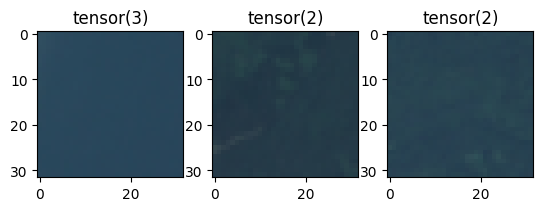

In [12]:
plt.subplot(1,3,1)
plt.imshow(feature[0].permute(1,2,0))
plt.title(labels[0])
plt.subplot(1,3,2)
plt.imshow(feature[15].permute(1,2,0))
plt.title(labels[15])
plt.subplot(1,3,3)
plt.imshow(feature[30].permute(1,2,0))
plt.title(labels[30])

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
model = torchvision.models.resnet50().to(device)

In [15]:
from torchinfo import summary
summary(model,[4507,3,32,32])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [4507, 1000]              --
├─Conv2d: 1-1                            [4507, 64, 16, 16]        9,408
├─BatchNorm2d: 1-2                       [4507, 64, 16, 16]        128
├─ReLU: 1-3                              [4507, 64, 16, 16]        --
├─MaxPool2d: 1-4                         [4507, 64, 8, 8]          --
├─Sequential: 1-5                        [4507, 256, 8, 8]         --
│    └─Bottleneck: 2-1                   [4507, 256, 8, 8]         --
│    │    └─Conv2d: 3-1                  [4507, 64, 8, 8]          4,096
│    │    └─BatchNorm2d: 3-2             [4507, 64, 8, 8]          128
│    │    └─ReLU: 3-3                    [4507, 64, 8, 8]          --
│    │    └─Conv2d: 3-4                  [4507, 64, 8, 8]          36,864
│    │    └─BatchNorm2d: 3-5             [4507, 64, 8, 8]          128
│    │    └─ReLU: 3-6                    [4507, 64, 8, 8]          --
│ 

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [17]:
from skorch import NeuralNetClassifier
from sklearn.metrics import accuracy_score
from skorch.callbacks import EpochScoring
accuracy = EpochScoring(scoring='accuracy', lower_is_better=False)

net = NeuralNetClassifier(
    module = model, 
    max_epochs=10, 
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,

    callbacks=[accuracy],
    device =device
)

In [18]:
X_train,y_train = next(iter(train_loader))
X_test,y_test = next(iter(test_loader))


In [19]:
net.fit(X_train, y_train)
val_accuracy = accuracy_score(y_true=y_test, y_pred=net.predict(X_test))  
print("Validation Accuracy:", val_accuracy)

  epoch    accuracy    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.5738        1.4375       0.5738    20506.1606  2.8631
      2      0.7847        0.6164       0.7847        0.4787  2.1031
      3      0.8346        0.4690       0.8346        0.4625  2.1144
      4      0.8535        0.3852       0.8535        0.3952  2.1205
      5      0.9079        0.3210       0.9079        0.2471  2.1129
      6      0.9123        0.2745       0.9123        0.2607  2.1197
      7      0.8812        0.2992       0.8812        0.2906  2.1227
      8      0.9134        0.2510       0.9134        0.2123  2.1254
      9      0.8368        0.2308       0.8368        0.4650  2.1322
     10      0.9223        0.2355       0.9223        0.2039  2.1350
Validation Accuracy: 0.904170363797693


## random sample

In [20]:
n_initial = 100
initial_idx = np.random.choice(range(len(train_loader)), size=n_initial, replace=True)
X_initial = X_train[initial_idx]
y_initial = y_train[initial_idx]
# generate the pool
# remove the initial data from the training dataset
X_pool = np.delete(X_train, initial_idx, axis=0)[:4507]
y_pool = np.delete(y_train, initial_idx, axis=0)[:4507]

In [21]:
from modAL.models import ActiveLearner

# initialize ActiveLearner
learner = ActiveLearner(
    estimator=net,
    X_training=X_initial, y_training=y_initial,
)


Re-initializing optimizer.
  epoch    accuracy    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.0000        2.5795       0.0000        3.1784  0.1511
      2      0.0000        1.0171       0.0000        5.1573  0.0600
      3      0.0000        0.2402       0.0000        3.4148  0.0597
      4      0.0000        0.0436       0.0000      252.3806  0.0611
      5      0.0000        0.0078       0.0000      941.8408  0.0607
      6      0.0000        0.0015       0.0000     2041.8748  0.0618
      7      0.0000        0.0003       0.0000     3472.3081  0.0606
      8      0.0000        0.0001       0.0000     5155.1406  0.0640
      9      0.0000        0.0000       0.0000     6924.0234  0.0631
     10      0.0000        0.0000       0.0000     8646.3887  0.0620


In [22]:
n_queries = 5
for idx in range(n_queries):
    print('Query no. %d' % (idx + 1))
    query_idx, query_instance = learner.query(X_pool, n_instances=100)
    learner.teach(
        X=X_pool[query_idx], y=y_pool[query_idx], only_new=True,
    )
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)
loss_random = net.history[:,'valid_loss']
accuracy_random = net.history[:,'valid_acc']

Query no. 1
Re-initializing optimizer.
  epoch    accuracy    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.2500       12.5270       0.2500  2011677.7500  0.0618
      2      0.2500        8.7970       0.2500   298448.4062  0.0622
      3      0.2500        4.2860       0.2500  1964996.7500  0.0614
      4      0.2500       17.8281       0.2500   338175.1250  0.0610
      5      0.2500       15.7572       0.2500   576186.0000  0.0619
      6      0.2500       17.0824       0.2500   481401.6875  0.0621
      7      0.3000        6.8400       0.3000   570384.4375  0.0609
      8      0.3000        1.6694       0.3000   747641.3750  0.0610
      9      0.3000        1.0855       0.3000   973750.0000  0.0619
     10      0.3000        0.8495       0.3000  1291433.0000  0.0627
Query no. 2
Re-initializing optimizer.
  epoch    accuracy    train_loss    valid_acc    valid_loss     dur
-------  ----------  ----

## entropy sample

In [23]:
n_initial = 100
initial_idx = np.random.choice(range(len(train_loader)), size=n_initial, replace=True)
X_initial = X_train[initial_idx]
y_initial = y_train[initial_idx]
# generate the pool
# remove the initial data from the training dataset
X_pool = np.delete(X_train, initial_idx, axis=0)[:4507]
y_pool = np.delete(y_train, initial_idx, axis=0)[:4507]

In [45]:
import modAL
from modAL.models import ActiveLearner
learner = ActiveLearner(
    estimator=net,
    query_strategy=modAL.uncertainty.entropy_sampling,
    X_training=X_train, y_training=y_train
)
loss_entropy = net.history[:,'valid_loss']
accuracy_entropy = net.history[:,'valid_acc']
# modAL.disagreement.consensus_entropy_sampling
val_accuracy = accuracy_score(y_true=y_test, y_pred=learner.predict(X_test))
print("Validation Accuracy:", val_accuracy)

Re-initializing optimizer.
  epoch    accuracy    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.7536        0.0989       0.7536        1.8921  2.3676
      2      0.9711        0.0370       0.9711        0.0843  2.2899
      3      0.9678        0.0438       0.9678        0.0958  2.2998
      4      0.9423        0.0853       0.9423        0.1876  2.3017
      5      0.9523        0.1063       0.9523        0.1591  2.3001
      6      0.9467        0.0989       0.9467        0.1509  2.3093
      7      0.9778        0.0808       0.9778        0.0662  2.3040
      8      0.9145        0.0679       0.9145        0.3386  2.3031
      9      0.9423        0.0405       0.9423        0.2095  2.3098
     10      0.8812        0.0356       0.8812        0.7768  2.3104
Validation Accuracy: 0.8837622005323869


[array([2]), array([2]), array([0]), array([1]), array([0])]
[tensor(3), tensor(3), tensor(0), tensor(1), tensor(0)]
[599, 536, 296, 260, 61]


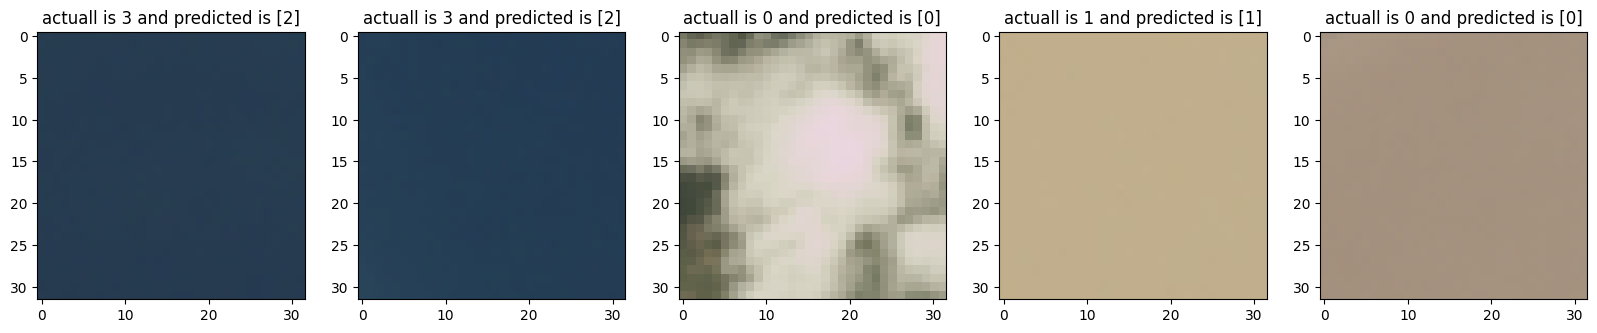

In [46]:
predictions =[]
actuall =[]
sample = []
for i in range(5):
    random_integer = np.random.randint(1000)
    pred = learner.predict(X_test[random_integer].unsqueeze(dim=0))
    predictions.append(pred)
    actuall.append(y_test[random_integer])
    sample.append(random_integer)
print(predictions)
print(actuall)
print(sample)
plt.figure(figsize=(20, 20))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X_test[sample[i]].permute(1,2,0))
    plt.title(f'actuall is {actuall[i]} and predicted is {predictions[i]}')
    

## uncertainty sampling


In [47]:
n_initial = 100
initial_idx = np.random.choice(range(len(train_loader)), size=n_initial, replace=True)
X_initial = X_train[initial_idx]
y_initial = y_train[initial_idx]
# generate the pool
# remove the initial data from the training dataset
X_pool = np.delete(X_train, initial_idx, axis=0)[:4507]
y_pool = np.delete(y_train, initial_idx, axis=0)[:4507]

In [48]:
from modAL.models import ActiveLearner
learner = ActiveLearner(
    estimator=net,
    query_strategy=modAL.uncertainty.uncertainty_sampling,
    X_training=X_train, y_training=y_train
)
loss_uncert = net.history[:,'valid_loss']
accuracy_uncert = net.history[:,'valid_acc']
val_accuracy = accuracy_score(y_true=y_test, y_pred=learner.predict(X_test))
print("Validation Accuracy:", val_accuracy)

Re-initializing optimizer.
  epoch    accuracy    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.8180        0.1023       0.8180        0.8554  2.3390
      2      0.8968        0.0591       0.8968        0.3105  2.2699
      3      0.8635        0.0382       0.8635        0.6316  2.2836
      4      0.9378        0.0335       0.9378        0.1934  2.2869
      5      0.9034        0.0274       0.9034        0.6268  2.2780
      6      0.7458        0.0450       0.7458        1.7803  2.2928
      7      0.8568        0.0392       0.8568        0.5159  2.3021
      8      0.9778        0.0244       0.9778        0.0731  2.3048
      9      0.8701        0.0238       0.8701        1.7822  2.3170
     10      0.9079        0.0255       0.9079        0.3516  2.3181
Validation Accuracy: 0.9094942324755989


[array([2]), array([3]), array([0]), array([0]), array([2])]
[tensor(2), tensor(3), tensor(0), tensor(0), tensor(2)]
[84, 943, 698, 230, 15]


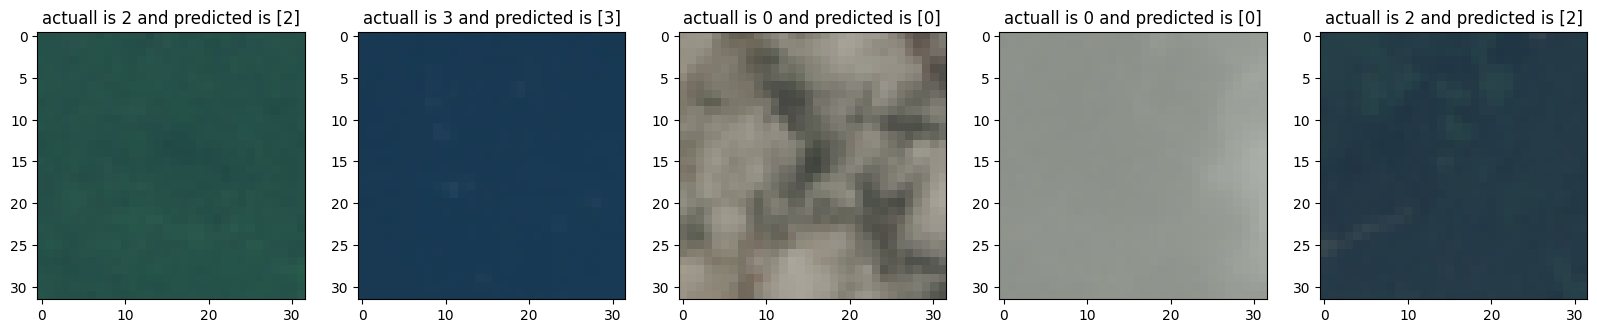

In [49]:
predictions =[]
actuall =[]
sample = []
for i in range(5):
    random_integer = np.random.randint(1000)
    pred = learner.predict(X_test[random_integer].unsqueeze(dim=0))
    predictions.append(pred)
    actuall.append(y_test[random_integer])
    sample.append(random_integer)
print(predictions)
print(actuall)
print(sample)
plt.figure(figsize=(20, 20))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X_test[sample[i]].permute(1,2,0))
    plt.title(f'actuall is {actuall[i]} and predicted is {predictions[i]}')
    

## disagrement

In [51]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
learner = ActiveLearner(
    estimator=net,
    query_strategy=modAL.disagreement.consensus_entropy_sampling,
    X_training=X_train, y_training=y_train
)
loss_dis = net.history[:,'valid_loss']
accuracy_dis = net.history[:,'valid_acc']
val_accuracy = accuracy_score(y_true=y_test, y_pred=learner.predict(X_test))
print("Validation Accuracy:", val_accuracy)

Re-initializing optimizer.
  epoch    accuracy    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.8269        0.5528       0.8269        1.3658  2.3388
      2      0.9301        0.0534       0.9301        0.4161  2.2574
      3      0.8912        0.0325       0.8912        0.7605  2.2520
      4      0.9634        0.0248       0.9634        0.2136  2.2571
      5      0.9811        0.0187       0.9811        0.1405  2.2710
      6      0.9711        0.0113       0.9711        0.1678  2.2840
      7      0.9012        0.0078       0.9012        0.7393  2.2855
      8      0.9656        0.0264       0.9656        0.2159  2.3038
      9      0.9745        0.0353       0.9745        0.1730  2.3103
     10      0.9367        0.0145       0.9367        0.3069  2.3240
Validation Accuracy: 0.935226264418811


[array([0]), array([0]), array([0]), array([2]), array([0])]
[tensor(0), tensor(0), tensor(0), tensor(2), tensor(0)]
[725, 360, 449, 882, 234]


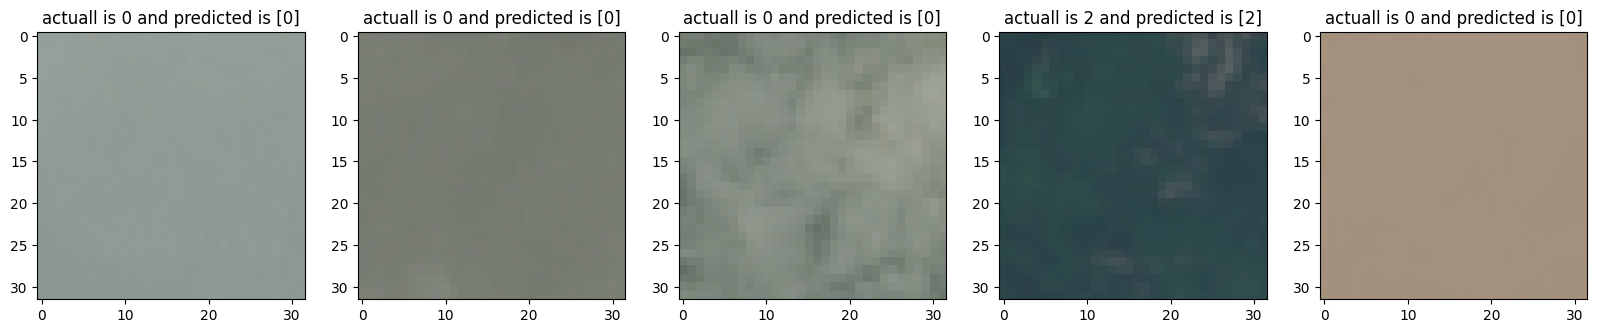

In [52]:
predictions =[]
actuall =[]
sample = []
for i in range(5):
    random_integer = np.random.randint(1000)
    pred = learner.predict(X_test[random_integer].unsqueeze(dim=0))
    predictions.append(pred)
    actuall.append(y_test[random_integer])
    sample.append(random_integer)
print(predictions)
print(actuall)
print(sample)
plt.figure(figsize=(20, 20))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X_test[sample[i]].permute(1,2,0))
    plt.title(f'actuall is {actuall[i]} and predicted is {predictions[i]}')
    

In [38]:
n_initial = 100
initial_idx = np.random.choice(range(len(train_loader)), size=n_initial, replace=True)
X_initial = X_train[initial_idx]
y_initial = y_train[initial_idx]
# generate the pool
# remove the initial data from the training dataset
X_pool = np.delete(X_train, initial_idx, axis=0)[:4507]
y_pool = np.delete(y_train, initial_idx, axis=0)[:4507]

In [40]:
epoches = net.history[:,'epoch']

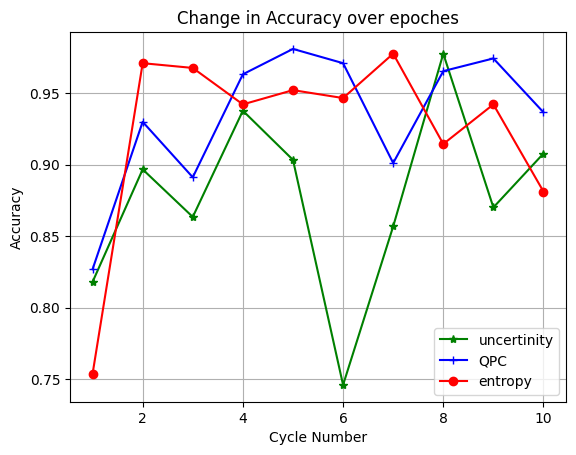

In [53]:
from matplotlib import pyplot as plt
plt.plot(epoches, accuracy_uncert, label='uncertinity',color='green',marker='*')
plt.plot(epoches, accuracy_dis,label='QPC',color='blue',marker='+')
plt.plot(epoches, accuracy_entropy,label='entropy',color='red',marker='o')
plt.xlabel('Cycle Number')
plt.ylabel('Accuracy')
plt.title('Change in Accuracy over epoches')
plt.legend()
plt.grid(True)
plt.show()


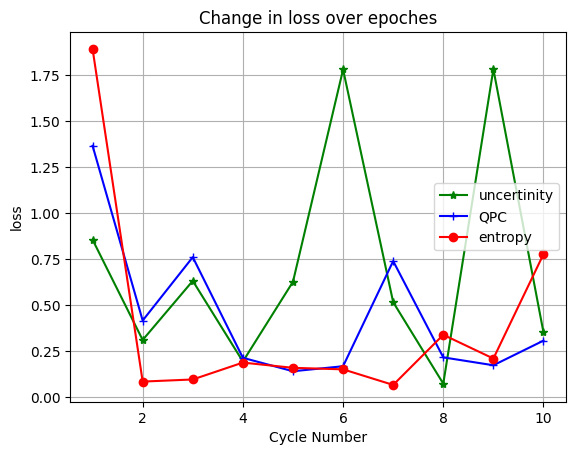

In [54]:
from matplotlib import pyplot as plt
plt.plot(epoches, loss_uncert, label='uncertinity',color='green',marker='*')
plt.plot(epoches, loss_dis,label='QPC',color='blue',marker='+')
plt.plot(epoches, loss_entropy,label='entropy',color='red',marker='o')
plt.xlabel('Cycle Number')
plt.ylabel('loss')
plt.title('Change in loss over epoches')
plt.legend()
plt.grid(True)
plt.show()
